## Compare different architectures and hyperparameters
### Main variables I played with
- number of layers
- number of nodes per layer (mostly: in first layer)
- embedding dimension
- dropout layer in first layer: Yes/No

In [2]:
import os
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ms2deepscore import SpectrumBinner
from ms2deepscore.models import SiameseModel

#ROOT = os.path.dirname(os.getcwd())
#sys.path.insert(0, ROOT)
path_root = os.path.dirname(os.path.dirname(os.getcwd()))
path_data = os.path.join(path_root, 'Data')
path_models = os.path.join(path_root, 'SURF_model_training_runs')

## Additional plotting function

In [3]:
def precision_recall_plot(scores_test, scores_ref,
                          high_sim_threshold=0.6,
                          n_bins = 20):
    """Basic precision recall plot"""
    precisions = []
    recalls = []

    above_thres_total = np.sum(scores_ref >= high_sim_threshold)
    max_score = scores_test.max()
    min_score = scores_test.min()
    score_thresholds = np.linspace(min_score, max_score, n_bins+1)
    for low in score_thresholds:
        idx = np.where(scores_test>=low)
        above_thres = np.sum(scores_ref[idx] >= high_sim_threshold)
        below_thres = np.sum(scores_ref[idx] < high_sim_threshold)

        precisions.append(above_thres/(below_thres+above_thres))
        recalls.append(above_thres/above_thres_total)

    plt.figure(figsize=(6,5), dpi=120)
    plt.plot(recalls, precisions, "o--", color="crimson", label="precision/recall")
    #plt.plot(score_thresholds, precisions, "o--", color="crimson", label="precision")
    #plt.plot(score_thresholds, recalls, "o--", color="dodgerblue", label="recall")
    plt.legend()
    plt.xlabel("recall", fontsize=12)
    plt.ylabel("precision", fontsize=12)
    plt.title(f"precision/recall (high-similarity if Tanimoto > {high_sim_threshold })")
    plt.grid(True)
    
    return precisions, recalls

In [4]:
def tanimoto_dependent_losses(scores, scores_ref, ref_score_bins):
    bin_content = []
    rmses = []
    maes = []
    bounds = []
    ref_scores_bins_inclusive = ref_score_bins.copy()
    ref_scores_bins_inclusive[0] = -np.inf
    ref_scores_bins_inclusive[-1] = np.inf
    for i in range(len(ref_scores_bins_inclusive)-1):
        low = ref_scores_bins_inclusive[i]
        high = ref_scores_bins_inclusive[i+1]
        bounds.append((low, high))
        idx = np.where((scores_ref >= low) & (scores_ref < high))
        bin_content.append(idx[0].shape[0])
        maes.append(np.abs(scores_ref[idx] - scores[idx]).mean())
        rmses.append(np.sqrt(np.square(scores_ref[idx] - scores[idx]).mean()))

    return bin_content, bounds, rmses, maes


def plot_tanimoto_dependent_losses(bin_content, bounds, rmses, maes):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6, 8), dpi=120)
    ax1.plot(np.arange(len(rmses)), maes, "o--")
    ax1.set_title('MAE')
    ax1.set_ylabel("MAE")
    #ax1.set_ylim(0)
    ax1.grid(True)
    
    ax2.plot(np.arange(len(rmses)), rmses, "o--", color="crimson")
    ax2.set_title('RMSE')
    ax2.set_ylabel("RMSE")
    #ax2.set_xlabel("score STD threshold")
    #ax2.set_ylim(0)
    ax2.grid(True)

    ax3.plot(bins[:-1], bin_content, "o--", color="teal")
    ax3.set_title('# of spectrum pairs')
    ax3.set_ylabel("# of spectrum pairs")
    ax3.set_xlabel("Tanimoto score bin")
    plt.xticks(np.arange(len(rmses)),
               [f"{a:.1f} to < {b:.1f}" for (a, b) in bounds], fontsize=9, rotation='vertical')
    #ax3.set_ylim(0)
    ax3.grid(True)
    

def tanimoto_dependent_STDs(scores_STD, scores_ref, bins):
    bin_content = []
    STDs = []
    for i in range(len(ref_score_bins)-1):
        low = ref_score_bins[i]
        high = ref_score_bins[i+1]
        idx = np.where((scores_ref >= low) & (scores_ref < high))
        bin_content.append(idx[0].shape[0])
        STDs.append(scores_STD[idx].mean())
    return bin_content, STDs   

### Load Tanimoto scores (=labels)

In [5]:
filename = os.path.join(path_data, 'ALL_GNPS_210125_positive_tanimoto_scores.pickle')
tanimoto_df = pd.read_pickle(filename)
tanimoto_df.head()

,TXZUPPVCNIMVHW,DGYASNDHNSXGSL,JWYUFVNJZUSCSM,ZQXBVPNSSGEUCM,WIOKWEJDRXNVSH,NJMQSVWMCODQIP,VBFKEZGCUWHGSK,KJAYXCCGPDNITQ,NTAHMPNXQOYXSX,YALMHTJLWDGANA,...,DCPZWPYLSMMJKM,BFZHCUBIASXHPK,IYUIDAWSRJAFII,YMGXBGVMAOTRFZ,ZOVBJSDLILDXCH,ZBAVIUQLFUYWMT,LBZHBTVSBILXAE,FQXXSQDCDRQNQE,PKKTXAMCHLIVDS,HDDNZVWBRRAOGK
TXZUPPVCNIMVHW,1.000000,0.351169,0.097595,0.454490,0.232465,0.350913,0.220788,0.369819,0.553414,0.488411,...,0.245836,0.197547,0.319240,0.170619,0.419412,0.111339,0.502242,0.609171,0.456767,0.364198
DGYASNDHNSXGSL,0.351169,1.000000,0.095344,0.311426,0.266393,0.306679,0.187037,0.241550,0.352905,0.346228,...,0.239921,0.196926,0.248181,0.224319,0.328424,0.134894,0.371523,0.395833,0.325097,0.267617
JWYUFVNJZUSCSM,0.097595,0.095344,1.000000,0.087488,0.096552,0.089779,0.075710,0.078571,0.101093,0.111277,...,0.087171,0.076667,0.090069,0.086042,0.097539,0.082902,0.100224,0.097547,0.091977,0.091603
ZQXBVPNSSGEUCM,0.454490,0.311426,0.087488,1.000000,0.158416,0.403968,0.223629,0.428328,0.476427,0.356584,...,0.190833,0.303226,0.309870,0.151724,0.382889,0.200405,0.419784,0.455195,0.301105,0.505532
WIOKWEJDRXNVSH,0.232465,0.266393,0.096552,0.158416,1.000000,0.170429,0.115108,0.148259,0.213307,0.193948,...,0.235054,0.100985,0.156159,0.146067,0.189189,0.065600,0.208011,0.223117,0.272388,0.147978


## Import validation data

In [6]:
import pickle
outfile = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_val_split_210301.pickle')
with open(outfile, 'rb') as file:
    spectrums_val = pickle.load(file)

print(f"{len(spectrums_val)} spectrums in test data.")

3597 spectrums in test data.


## Define evaluation workflow

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model
from ms2deepscore import MS2DeepScore

def evaluate_model(keras_model_file, spectrum_binner_file, spectrums, scores_ref,
                   save_predictions=False):

    # Load spectrum binner
    with open(spectrum_binner_file, 'rb') as file:
        spectrum_binner = pickle.load(file) 
    # Load keras model
    keras_model = load_keras_model(keras_model_file)
    
    # Create Siamese model
    model = SiameseModel(spectrum_binner, keras_model=keras_model)
    
    # Calculate scores
    similarity_score = MS2DeepScore(model)
    predictions = similarity_score.matrix(spectrums, spectrums, is_symmetric=True)
    if save_predictions:
        np.save(save_predictions, predictions)
    
    # Compare predicted with actual scores
    bin_content, _, rmses, maes = tanimoto_dependent_losses(predictions, scores_ref, ref_score_bins)

    return bin_content, rmses, maes

In [8]:
inchikey_idx_val = np.zeros(len(spectrums_val))
for i, spec in enumerate(spectrums_val):
    inchikey_idx_val[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_val = inchikey_idx_val.astype("int")
print(np.unique(inchikey_idx_val).shape)

(500,)


---
# Screens 1: network width (no. of nodes/layer)

In [15]:
scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_val[:], inchikey_idx_val[:])].copy()
ref_score_bins = np.linspace(0,1.0, 11)

In [24]:
model_files = ["20210329-111647_Test_10k_200_200_200.hdf5",
               "20210326-191145_Test_10k_500_500_200.hdf5",
               "20210329-111913_Test_10k_800_800_200.hdf5",
               "20210329-175627_Test_10k_1200_1200_200.hdf5"]

binner_files = 4*[os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')]

predictions_files = ["predictions_val_20210329-111647_Test_10k_200_200_200.npy",
                    "predictions_val_20210326-191145_Test_10k_500_500_200.npy",
                    "predictions_val_20210329-111913_Test_10k_800_800_200.npy",
                    "predictions_val_20210329-175627_Test_10k_1200_1200_200.npy"]

bin_content_collection = []
rmses_collection = []
maes_collection = []

for i in range(4):
    print(f"Run evaluation no. {i} ----------------------------")
    keras_model_file = os.path.join(path_models, "trained_models", model_files[i])
    spectrum_binner_file = binner_files[i]
    predictions_file = os.path.join(path_models, "trained_models", predictions_files[i])
    
    bin_content, rmses, maes = evaluate_model(keras_model_file, spectrum_binner_file,
                                              spectrums_val, scores_ref,
                                              save_predictions=predictions_file)
    bin_content_collection.append(bin_content)
    rmses_collection.append(rmses)
    maes_collection.append(maes)
    

Run evaluation no. 0 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:09<00:00, 14.41it/s]


Run evaluation no. 1 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:07<00:00, 14.52it/s]


Run evaluation no. 2 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:10<00:00, 14.34it/s]


Run evaluation no. 3 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:51<00:00, 12.34it/s]


In [66]:
# add data point
i = 4
print(f"Run evaluation no. {i} ----------------------------")
keras_model_file = os.path.join(path_models, "trained_models", "20210330-140903_Test_10k_100_100_200.hdf5")
spectrum_binner_file = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')
predictions_file = os.path.join(path_models, "trained_models", "predictions_val_20210330-140903_Test_10k_100_100_200.npy")

bin_content, rmses, maes = evaluate_model(keras_model_file, spectrum_binner_file,
                                          spectrums_val, scores_ref,
                                          save_predictions=predictions_file)
bin_content_collection.append(bin_content)
rmses_collection.append(rmses)
maes_collection.append(maes)



Run evaluation no. 4 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:10<00:00, 14.37it/s]


In [199]:
# add data point
i = 5
print(f"Run evaluation no. {i} ----------------------------")
keras_model_file = os.path.join(path_models, "trained_models", "20210330-213719_Test_10k_20_20_200.hdf5")
spectrum_binner_file = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')
predictions_file = os.path.join(path_models, "trained_models", "predictions_val_20210330-213719_Test_10k_20_20_200.npy")

bin_content, rmses, maes = evaluate_model(keras_model_file, spectrum_binner_file,
                                          spectrums_val, scores_ref,
                                          save_predictions=predictions_file)
bin_content_collection.append(bin_content)
rmses_collection.append(rmses)
maes_collection.append(maes)

Run evaluation no. 5 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:26<00:00, 13.48it/s]


In [200]:
rmses_collection_width = [rmses_collection[i] for i in [5,4,0,1,2,3]]
maes_collection_width = [maes_collection[i] for i in [5,4,0,1,2,3]]

In [201]:
np.save(os.path.join(path_models, "trained_models", "screens_width_maes.npy"), maes_collection_width)
np.save(os.path.join(path_models, "trained_models", "screens_width_rmses.npy"), rmses_collection_width)
np.save(os.path.join(path_models, "trained_models", "screens_width_bin_content.npy"), bin_content)

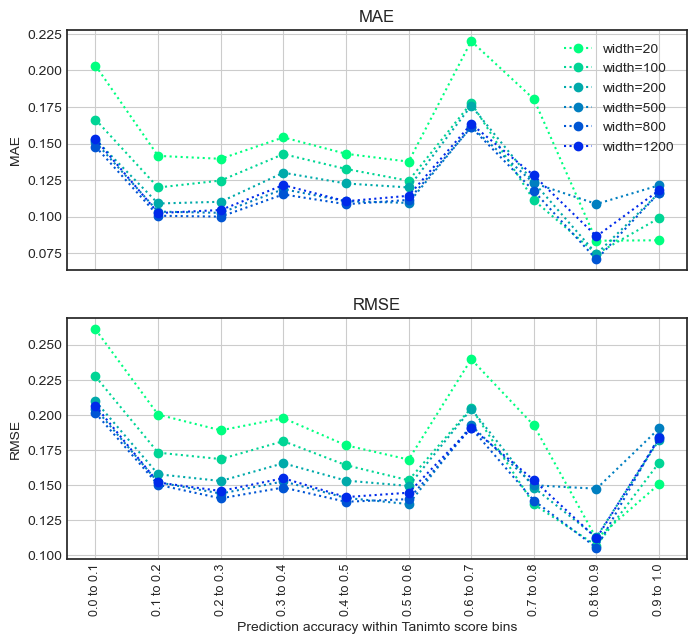

In [213]:
import matplotlib
cmap = matplotlib.cm.get_cmap('winter_r')

bounds = [f"{a:.1f} to {a+0.1:.1f}" for a in ref_score_bins[:-1]]
labels = [f"width={x}" for x in [20, 100, 200, 500, 800, 1200]]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7), dpi=100)
for i in range(6):
    ax1.plot(ref_score_bins[:-1], maes_collection_width[i], "o:", color=cmap(i/6), label=labels[i])
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)
ax1.legend()

for i in range(6):
    ax2.plot(ref_score_bins[:-1], rmses_collection_width[i], "o:", color=cmap(i/6), label=labels[i])
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
#ax2.set_ylim(0)
ax2.grid(True)
plt.xticks(ref_score_bins[:-1],
           bounds, fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within Tanimto score bins")
plt.savefig("screens_width_tanimoto_dependent_accuracy.pdf")

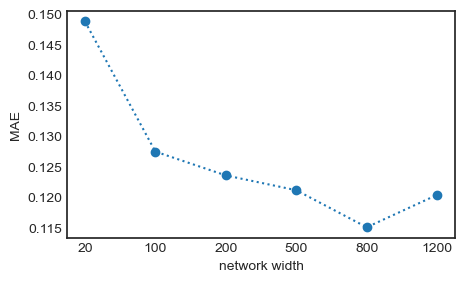

In [204]:
maes_means = [np.mean(x) for x in maes_collection_width]
maes_std = [np.std(x) for x in maes_collection_width]
rmses_means = [np.mean(x) for x in rmses_collection_width]
rmses_std= [np.std(x) for x in rmses_collection_width]

plt.figure(figsize=(5,3), dpi=100)
#plt.errorbar(np.arange(4), maes_means, yerr=maes_var, label='both limits (default)')
plt.plot([maes_means[i] for i in [0,1,2,3,4,5]], "o:")
plt.xticks(np.arange(6), ["20", "100", "200", "500", "800", "1200"])
plt.xlabel("network width")
plt.ylabel("MAE")
plt.savefig("screens_width_MAE.pdf")

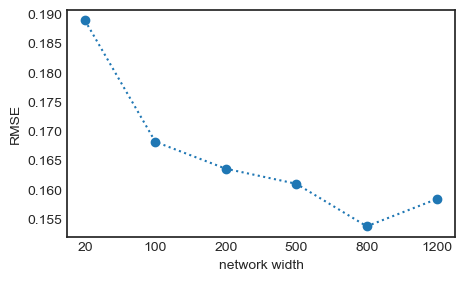

In [205]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot([rmses_means[i] for i in [0,1,2,3,4,5]], "o:")
plt.xticks(np.arange(6), ["20", "100", "200", "500", "800", "1200"])
plt.xlabel("network width")
plt.ylabel("RMSE")
plt.savefig("screens_width_RMSE.pdf")

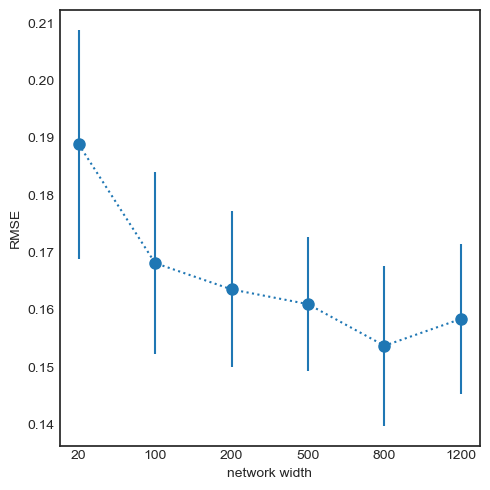

In [211]:
plt.figure(figsize=(5,5), dpi=100)
plt.errorbar(np.arange(6), [rmses_means[i] for i in [0,1,2,3,4,5]],
             yerr=[0.5*rmses_std[i] for i in [0,1,2,3,4,5]],
             marker='o', markersize=8,
             linestyle="dotted")
plt.xticks(np.arange(6), ["20","100", "200", "500", "800", "1200"])
plt.xlabel("network width")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig("screens_width_RMSE_std.pdf")

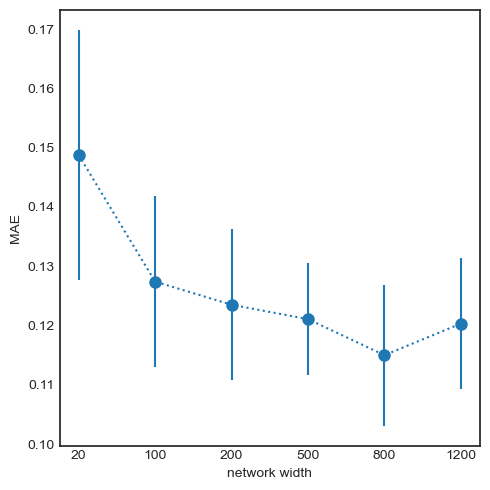

In [210]:
plt.figure(figsize=(5,5), dpi=100)
plt.errorbar(np.arange(6), [maes_means[i] for i in [0,1,2,3,4,5]],
             yerr=[0.5*maes_std[i] for i in [0,1,2,3,4,5]],
             marker='o', markersize=8,
             linestyle="dotted")

plt.xticks(np.arange(6), ["20", "100", "200", "500", "800", "1200"])
plt.xlabel("network width")
plt.ylabel("MAE")
plt.tight_layout()
plt.savefig("screens_width_MAE_std.pdf")

In [234]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_val_20210330-213719_Test_10k_20_20_200.npy")
predictions_20_20 = np.load(predictions_file)

predictions_file = os.path.join(path_models, "trained_models", "predictions_val_20210329-111913_Test_10k_800_800_200.npy")
predictions_800_800 = np.load(predictions_file)

predictions_file = os.path.join(path_models, "trained_models", "predictions_val_20210329-175627_Test_10k_1200_1200_200.npy")
predictions_1200_1200 = np.load(predictions_file)

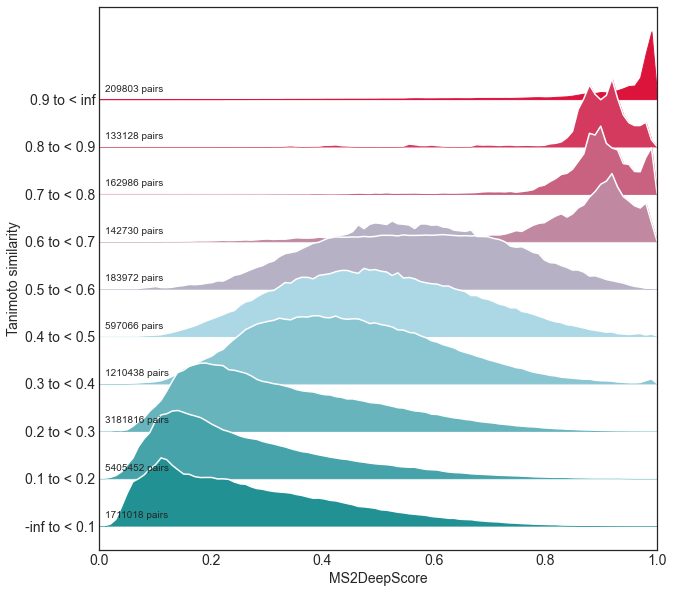

In [233]:
create_histograms_plot(scores_ref, predictions_20_20, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

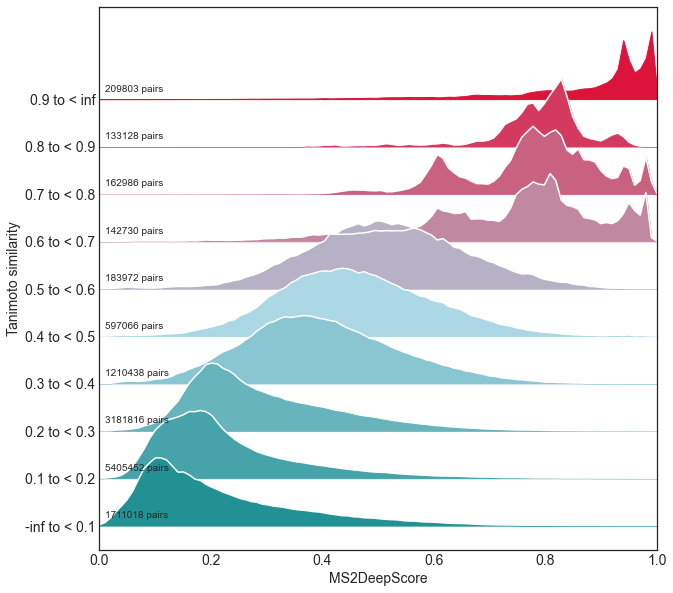

In [232]:
create_histograms_plot(scores_ref, predictions_800_800, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

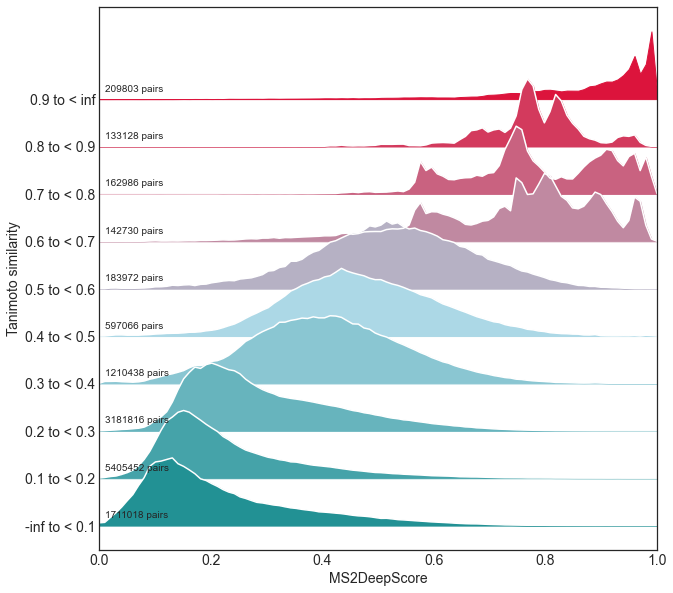

In [235]:
create_histograms_plot(scores_ref, predictions_1200_1200, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

---
# Screens 2: spectrum binning

In [60]:
model_files = ["20210328-220642_Test_1k_500_500_200.hdf5",
               "20210328-161821_Test_2k_500_500_200.hdf5",
               "20210328-161910_Test_5k_500_500_200.hdf5",
               "20210326-191145_Test_10k_500_500_200.hdf5",
               "20210328-201905_Test_15k_500_500_200.hdf5"]

binner_files = [os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210301_spectrum_binner_binned1k_meta.pickle'),
                os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210301_spectrum_binner_binned2k_meta.pickle'),
                os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210301_spectrum_binner_binned5k_meta.pickle'),
                os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle'),
                os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210301_spectrum_binner_binned15k_meta.pickle')]

predictions_files = ["predictions_val_20210328-220642_Test_1k_500_500_200.npy",
                    "predictions_val_20210328-161821_Test_2k_500_500_200.npy",
                    "predictions_val_20210328-161910_Test_5k_500_500_200.npy",
                    "predictions_val_20210326-191145_Test_10k_500_500_200.npy",
                    "predictions_val_20210328-201905_Test_15k_500_500_200.npy"]

bin_content_collection2 = []
rmses_collection2 = []
maes_collection2 = []

for i in range(4):
    print(f"Run evaluation no. {i} ----------------------------")
    keras_model_file = os.path.join(path_models, "trained_models", model_files[i])
    spectrum_binner_file = binner_files[i]
    predictions_file = os.path.join(path_models, "trained_models", predictions_files[i])
    
    bin_content, rmses, maes = evaluate_model(keras_model_file, spectrum_binner_file,
                                              spectrums_val, scores_ref,
                                              save_predictions=predictions_file)
    bin_content_collection2.append(bin_content)
    rmses_collection2.append(rmses)
    maes_collection2.append(maes)
    

Run evaluation no. 0 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:13<00:00, 14.18it/s]


Run evaluation no. 1 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [03:43<00:00, 16.12it/s]


Run evaluation no. 2 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:40<00:00, 12.81it/s]


Run evaluation no. 3 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:25<00:00, 13.54it/s]


In [63]:
i = 4
print(f"Run evaluation no. {i} ----------------------------")
keras_model_file = os.path.join(path_models, "trained_models", model_files[i])
spectrum_binner_file = binner_files[i]
predictions_file = os.path.join(path_models, "trained_models", predictions_files[i])

bin_content, rmses, maes = evaluate_model(keras_model_file, spectrum_binner_file,
                                          spectrums_val, scores_ref,
                                          save_predictions=predictions_file)
bin_content_collection2.append(bin_content)
rmses_collection2.append(rmses)
maes_collection2.append(maes)

Run evaluation no. 4 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [05:11<00:00, 11.54it/s]


In [111]:
i = 5
print(f"Run evaluation no. {i} ----------------------------")
keras_model_file = os.path.join(path_models, "trained_models", "20210330-163710_Test_500_500_500_200.hdf5")
spectrum_binner_file = os.path.join(path_data, 'GNPS_all', "ALL_GNPS_210301_spectrum_binner_binned500_meta.pickle")
predictions_file = os.path.join(path_models, "trained_models", "predictions_val_20210330-163710_Test_500_500_500_200.npy")

bin_content, rmses, maes = evaluate_model(keras_model_file, spectrum_binner_file,
                                          spectrums_val, scores_ref,
                                          save_predictions=predictions_file)
bin_content_collection2.append(bin_content)
rmses_collection2.append(rmses)
maes_collection2.append(maes)

Run evaluation no. 5 ----------------------------


Calculating vectors of reference spectrums: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3597/3597 [04:12<00:00, 14.27it/s]


In [162]:
# sort by number of bins
maes_collection_binning = [maes_collection2[i] for i in [5,0,1,2,3,4]]
rmses_collection_binning = [rmses_collection2[i] for i in [5,0,1,2,3,4]]

ValueError: Unknown format code 'f' for object of type 'str'

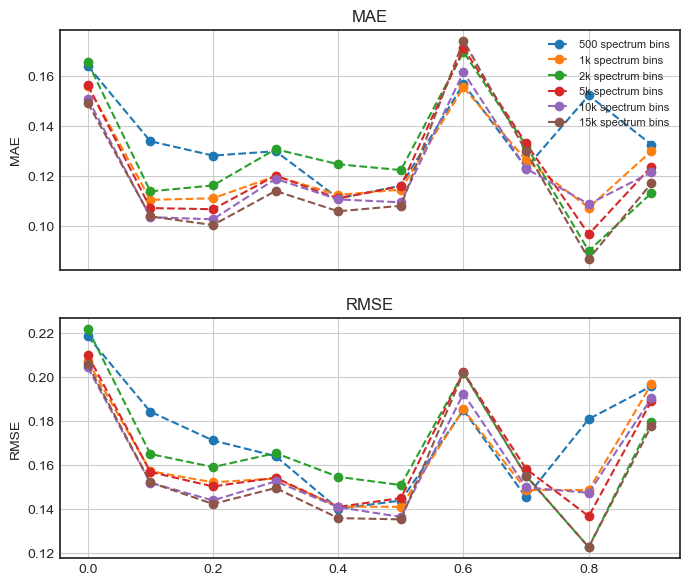

In [212]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7), dpi=100)

labels = [f"{x} spectrum bins" for x in ["500", "1k", "2k", "5k", "10k", "15k"]]
for i in range(6):
    ax1.plot(ref_score_bins[:-1], maes_collection_binning[i], "o--", label=labels[i])
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)
ax1.legend(fontsize=8)

for i in range(6):
    ax2.plot(ref_score_bins[:-1], rmses_collection_binning[i], "o--", label=labels[i])
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
#ax2.set_xlabel("score STD threshold")
#ax2.set_ylim(0)
ax2.grid(True)
plt.xticks(ref_score_bins[:-1],
           [f"{x[0]:.1f} to {x[1]:.1f}" for x in bounds], fontsize=9, rotation='vertical')
plt.savefig("screens_binning_tanimoto_dependent_accuracy.pdf")

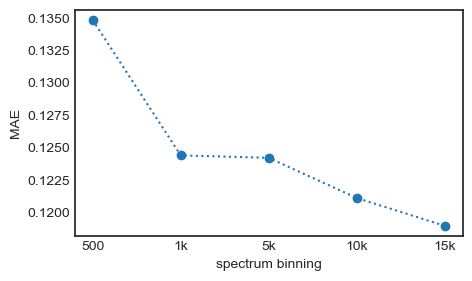

In [166]:
binning_maes_means = [np.mean(x) for x in maes_collection_binning]
binning_maes_std = [np.std(x) for x in maes_collection_binning]
binning_rmses_means = [np.mean(x) for x in rmses_collection_binning]
binning_rmses_std= [np.std(x) for x in rmses_collection_binning]

plt.figure(figsize=(5,3), dpi=100)
#plt.errorbar(np.arange(4), maes_means, yerr=maes_var, label='both limits (default)')
plt.plot([binning_maes_means[i] for i in [0,1,3,4,5]], "o:")
plt.xticks(np.arange(5), ["500", "1k", "5k", "10k", "15k"])
plt.xlabel("spectrum binning")
plt.ylabel("MAE")
plt.savefig("screens_binning_MAE.pdf")

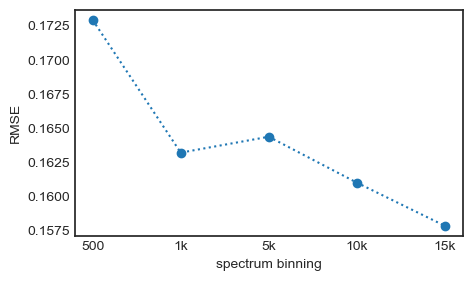

In [167]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot([binning_rmses_means[i] for i in [0,1,3,4,5]], "o:")
plt.xticks(np.arange(5), ["500","1k", "5k", "10k", "15k"])
plt.xlabel("spectrum binning")
plt.ylabel("RMSE")
plt.savefig("screens_binning_RMSE.pdf")

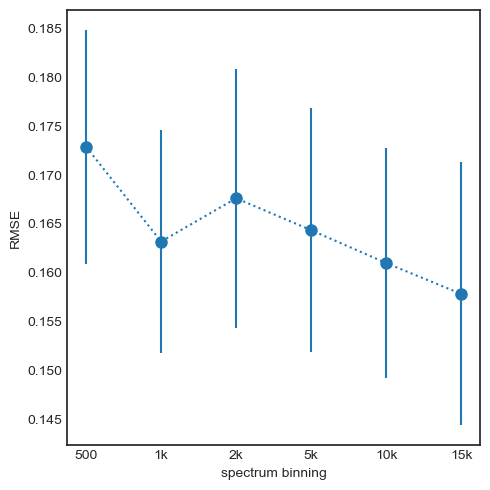

In [169]:
plt.figure(figsize=(5,5), dpi=100)
plt.errorbar(np.arange(6), [binning_rmses_means[i] for i in [0,1,2,3,4,5]],
             yerr=[0.5*binning_rmses_std[i] for i in [0,1,2,3,4,5]],
             marker='o', markersize=8,
             linestyle="dotted")
#plt.plot([rmses_means[i] for i in [4,0,1,2,3]], "o:")
plt.xticks(np.arange(6), ["500", "1k", "2k","5k", "10k", "15k"])
plt.xlabel("spectrum binning")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig("screens_binning_RMSE_std.pdf")

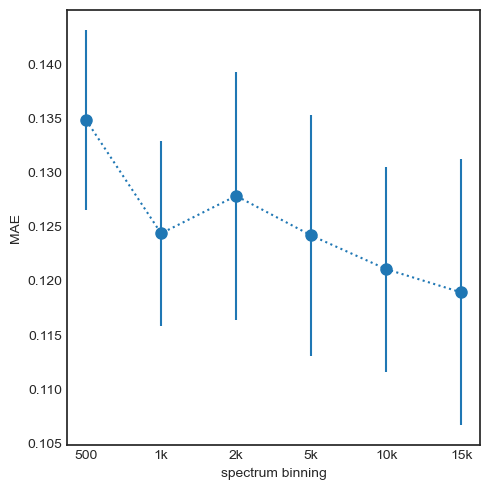

In [170]:
plt.figure(figsize=(5,5), dpi=100)
plt.errorbar(np.arange(6), [binning_maes_means[i] for i in [0,1,2,3,4,5]],
             yerr=[0.5*binning_maes_std[i] for i in [0,1,2,3,4,5]],
             marker='o', markersize=8,
             linestyle="dotted")
#plt.plot([rmses_means[i] for i in [4,0,1,2,3]], "o:")
plt.xticks(np.arange(6), ["500", "1k", "2k","5k", "10k", "15k"])
plt.xlabel("spectrum binning")
plt.ylabel("MAE")
plt.tight_layout()
plt.savefig("screens_binning_MAE_std.pdf")

---
# Screens 3: network deepth (no. of layers)

In [9]:
scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_val[:], inchikey_idx_val[:])].copy()
ref_score_bins = np.linspace(0,1.0, 11)

In [10]:
model_files = ["ms2ds_210301_10k_500_200.hdf5",
               "20210326-191145_Test_10k_500_500_200.hdf5",
               "20210326-191145_Test_10k_500_500_500_200.hdf5",
               "20210326-191145_Test_10k_500_500_500_500_200.hdf5"]

binner_files = 4*[os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_training_spectrum_binner_210301_10k.pickle')]

predictions_files = ["predictions_val_ms2ds_210301_10k_500_200.npy",
                    "predictions_val_20210326-191145_Test_10k_500_500_200.npy",
                    "predictions_val_20210326-191145_Test_10k_500_500_500_200.npy",
                    "predictions_val_20210326-191145_Test_10k_500_500_500_500_200.npy"]

bin_content_collection = []
rmses_collection = []
maes_collection = []

for i in range(4):
    print(f"Run evaluation no. {i} ----------------------------")
    keras_model_file = os.path.join(path_models, "trained_models", model_files[i])
    spectrum_binner_file = binner_files[i]
    predictions_file = os.path.join(path_models, "trained_models", predictions_files[i])
    
    bin_content, rmses, maes = evaluate_model(keras_model_file, spectrum_binner_file,
                                              spectrums_val, scores_ref,
                                              save_predictions=predictions_file)
    bin_content_collection.append(bin_content)
    rmses_collection.append(rmses)
    maes_collection.append(maes)
    

Run evaluation no. 0 ----------------------------


Spectrum binning: 100%|█| 3597/3597 [00:19<00:00, 186
Create BinnedSpectrum instances: 100%|█| 3597/3597 [0
Calculating vectors of reference spectrums: 100%|█| 3


Run evaluation no. 1 ----------------------------


Spectrum binning: 100%|█| 3597/3597 [00:23<00:00, 152
Create BinnedSpectrum instances: 100%|█| 3597/3597 [0
Calculating vectors of reference spectrums: 100%|█| 3


Run evaluation no. 2 ----------------------------


Spectrum binning: 100%|█| 3597/3597 [00:21<00:00, 164
Create BinnedSpectrum instances: 100%|█| 3597/3597 [0
Calculating vectors of reference spectrums: 100%|█| 3


Run evaluation no. 3 ----------------------------


Spectrum binning: 100%|█| 3597/3597 [00:21<00:00, 167
Create BinnedSpectrum instances: 100%|█| 3597/3597 [0
Calculating vectors of reference spectrums: 100%|█| 3


In [11]:
np.save(os.path.join(path_models, "trained_models", "screens_deepth_maes.npy"), maes_collection)
np.save(os.path.join(path_models, "trained_models", "screens_deepth_rmses.npy"), rmses_collection)
np.save(os.path.join(path_models, "trained_models", "screens_deepth_bin_content.npy"), bin_content)

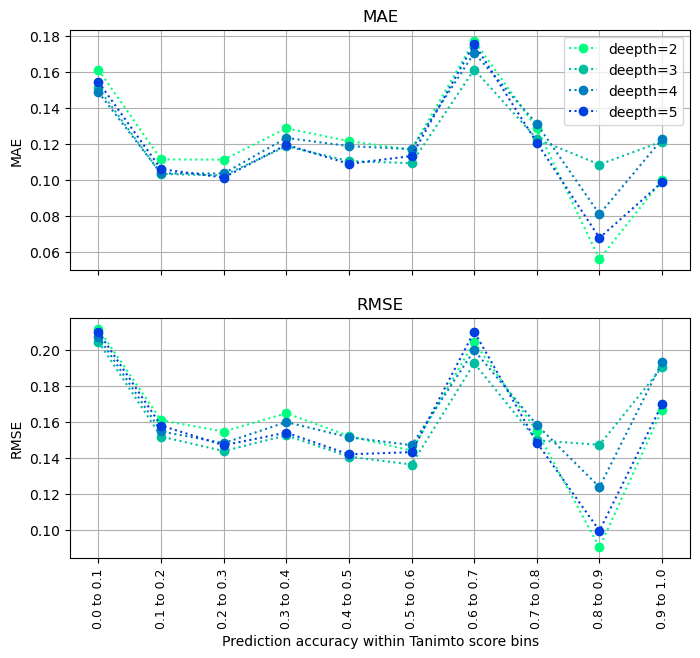

In [14]:
import matplotlib
cmap = matplotlib.cm.get_cmap('winter_r')

bounds = [f"{a:.1f} to {a+0.1:.1f}" for a in ref_score_bins[:-1]]
labels = [f"deepth={x}" for x in [2, 3, 4, 5]]
N = len(labels)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7), dpi=100)
for i in range(N):
    ax1.plot(ref_score_bins[:-1], maes_collection[i], "o:", color=cmap(i/N), label=labels[i])
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)
ax1.legend()

for i in range(N):
    ax2.plot(ref_score_bins[:-1], rmses_collection[i], "o:", color=cmap(i/N), label=labels[i])
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
#ax2.set_ylim(0)
ax2.grid(True)
plt.xticks(ref_score_bins[:-1],
           bounds, fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within Tanimto score bins")
plt.savefig("screens_deepth_tanimoto_dependent_accuracy.pdf")

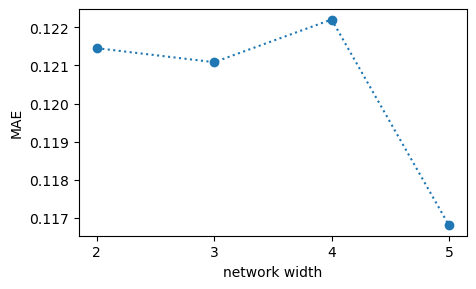

In [17]:
maes_means = [np.mean(x) for x in maes_collection]
maes_std = [np.std(x) for x in maes_collection]
rmses_means = [np.mean(x) for x in rmses_collection]
rmses_std= [np.std(x) for x in rmses_collection]

plt.figure(figsize=(5,3), dpi=100)
#plt.errorbar(np.arange(4), maes_means, yerr=maes_var, label='both limits (default)')
plt.plot([maes_means[i] for i in [0,1,2,3]], "o:")
plt.xticks(np.arange(4), [2,3,4,5])
plt.xlabel("network width")
plt.ylabel("MAE")
plt.savefig("screens_deepth_MAE.pdf")

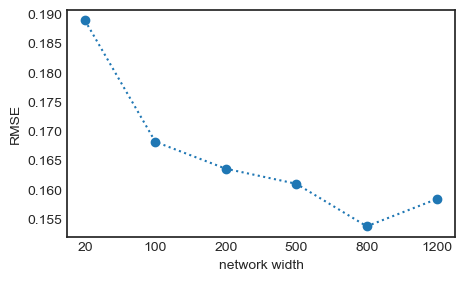

In [205]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot([rmses_means[i] for i in [0,1,2,3,4,5]], "o:")
plt.xticks(np.arange(6), ["20", "100", "200", "500", "800", "1200"])
plt.xlabel("network width")
plt.ylabel("RMSE")
plt.savefig("screens_width_RMSE.pdf")

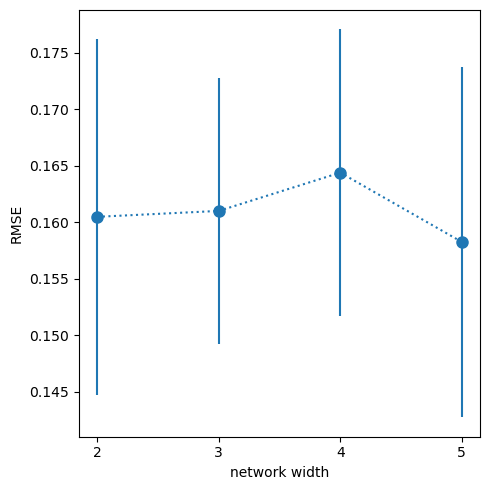

In [20]:
plt.figure(figsize=(5,5), dpi=100)
plt.errorbar(np.arange(4), [rmses_means[i] for i in [0,1,2,3]],
             yerr=[0.5*rmses_std[i] for i in [0,1,2,3]],
             marker='o', markersize=8,
             linestyle="dotted")
plt.xticks(np.arange(4), [2,3,4,5])
plt.xlabel("network width")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig("screens_deepth_RMSE_std.pdf")

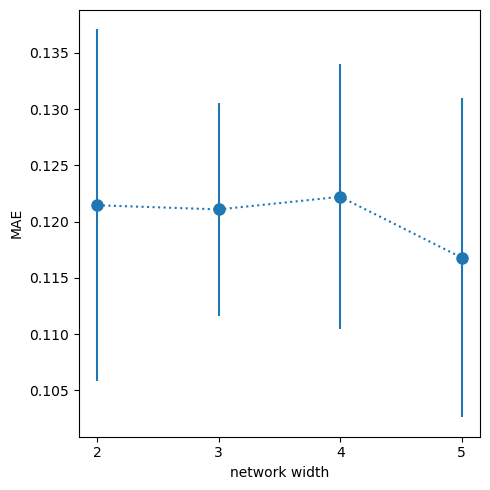

In [21]:
plt.figure(figsize=(5,5), dpi=100)
plt.errorbar(np.arange(4), [maes_means[i] for i in [0,1,2,3]],
             yerr=[0.5*maes_std[i] for i in [0,1,2,3]],
             marker='o', markersize=8,
             linestyle="dotted")

plt.xticks(np.arange(4), [2,3,4,5])
plt.xlabel("network width")
plt.ylabel("MAE")
plt.tight_layout()
plt.savefig("screens_deepth_MAE_std.pdf")

---
# TEST for fun: ensembling!

In [141]:
predictions_files = ["predictions_val_20210328-220642_Test_1k_500_500_200.npy",
                    "predictions_val_20210328-161821_Test_2k_500_500_200.npy",
                    "predictions_val_20210328-161910_Test_5k_500_500_200.npy",
                    "predictions_val_20210326-191145_Test_10k_500_500_200.npy",
                    "predictions_val_20210328-201905_Test_15k_500_500_200.npy"]

dim = len(spectrums_val)
predictions_ensemble = np.zeros((5, dim, dim))
for i, pred_file in enumerate(predictions_files):
    predictions_file = os.path.join(path_models, "trained_models", pred_file)
    predictions_ensemble[i, :, :] = np.load(predictions_file)

In [142]:
predictions_ensemble.shape

(5, 3597, 3597)

In [143]:
np.mean(predictions_ensemble, axis=0).shape

(3597, 3597)

In [148]:
bin_content, bounds, rmses, maes = tanimoto_dependent_losses(np.median(predictions_ensemble, axis=0), scores_ref, ref_score_bins)

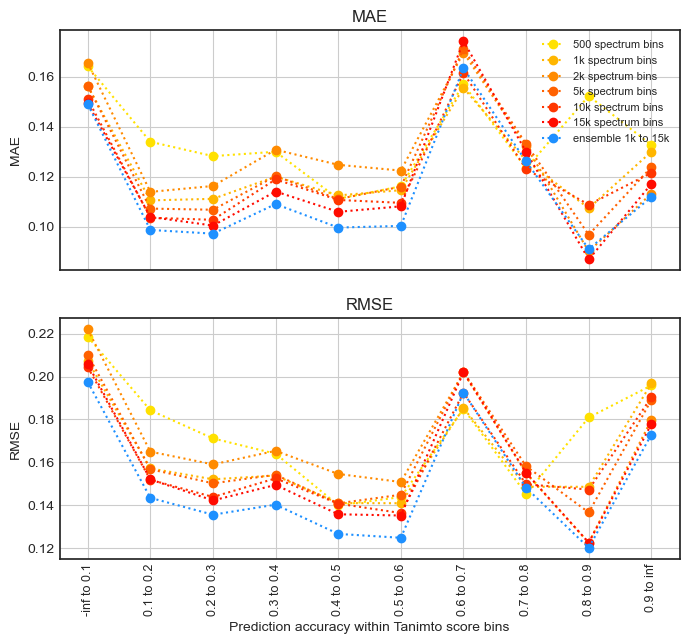

In [197]:
import matplotlib
cmap = matplotlib.cm.get_cmap('autumn_r')


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 7), dpi=100)

labels = [f"{x} spectrum bins" for x in ["500", "1k", "2k", "5k", "10k", "15k"]]
for i in range(6):
    ax1.plot(ref_score_bins[:-1], maes_collection_binning[i], "o:", color=cmap(0.12+i/6), label=labels[i])
ax1.plot(ref_score_bins[:-1], maes, "o:", color="dodgerblue", label="ensemble 1k to 15k")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
#ax1.set_ylim(0)
ax1.grid(True)
ax1.legend(fontsize=8)

for i in range(6):
    ax2.plot(ref_score_bins[:-1], rmses_collection_binning[i], "o:", color=cmap(0.12+i/6), label=labels[i])
ax2.plot(ref_score_bins[:-1], rmses, "o:", color="dodgerblue", label="ensemble 1k to 15k")
ax2.set_title('RMSE')
ax2.set_ylabel("RMSE")
#ax2.set_xlabel("score STD threshold")
#ax2.set_ylim(0)
ax2.grid(True)
plt.xticks(ref_score_bins[:-1],
           [f"{x[0]:.1f} to {x[1]:.1f}" for x in bounds], fontsize=9, rotation='vertical')
plt.xlabel("Prediction accuracy within Tanimto score bins")
plt.savefig("screens_binning_tanimoto_dependent_accuracy_plusENSEMBLE.pdf")

In [214]:
predictions_file = os.path.join(path_models, "trained_models", "predictions_val_20210330-213719_Test_10k_20_20_200.npy")
predictions_500 = np.load(predictions_file)

In [227]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def create_histograms_plot(reference_scores, comparison_scores, n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore"):
    """
    Plot histograms to compare reference and comparison scores.

    Parameters
    ----------
    reference_scores
        Reference score array.
    comparison_scores
        Comparison score array.
    n_bins
        Number of bins. The default is 5.
    hist_resolution
        Histogram resolution. The default is 100.
    ref_score_name
        Label string. The default is "Tanimoto similarity".
    compare_score_name
        Label string. The default is "MS2DeepScore".

    """
    # pylint: disable=too-many-arguments
    histograms, used_bins, bin_content = calculate_histograms(reference_scores, comparison_scores,
                                                              n_bins, hist_resolution)

    plot_histograms(histograms, used_bins, bin_content, xlabel=compare_score_name, ylabel=ref_score_name)


def plot_histograms(histograms, y_score_bins, bin_content=None,
                    xlabel="MS2DeepScore", ylabel="Tanimoto similarity"):
    """Create histogram based score comparison.
    """

    # Setup plotting stuff
    colors = ["crimson", "lightblue", "teal"]
    cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
    plt.style.use('seaborn-white')
    shift = 0.7
    alpha = 1.0 #0.5

    # Create plot
    plt.figure(figsize=(10,10))

    for i in range(0, len(histograms)):
        data = histograms[len(histograms)-i-1][0]
        data = data/max(data)
        plt.fill_between(histograms[0][1][:100], -shift*i, [(-shift*i + x) for x in data], color=cmap1(i/10), alpha=alpha)
        if i > 0:
            plt.plot(histograms[0][1][:100], [(-shift*i + x) for x in data], color="white")
        if bin_content:
            plt.text(0.01, -shift*i+shift/6, f"{bin_content[::-1][i]} pairs")#, color="white")

    plt.xticks(fontsize=14)
    plt.yticks(-shift*np.arange(len(histograms)),
               [f"{a:.1f} to < {b:.1f}" for (a, b) in y_score_bins[::-1]], fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlim([0, 1])


def calculate_histograms(reference_scores, comparison_scores, n_bins=10, hist_resolution=100):
    """Calcualte a series of histograms, one for every bin."""
    d_bin = 1/n_bins
    hist_bins = np.linspace(0, 1, hist_resolution)
    hist_bins = np.concatenate((hist_bins, np.array([2.0])))

    histograms = []
    used_bins = []
    bin_content = []
    ref_scores_bins_inclusive = np.linspace(0, 1, n_bins+1)
    ref_scores_bins_inclusive[0] = -np.inf
    ref_scores_bins_inclusive[-1] = np.inf
    
    for i in range(n_bins):
        used_bins.append((ref_scores_bins_inclusive[i], ref_scores_bins_inclusive[i+1]))
        idx = np.where((reference_scores >= ref_scores_bins_inclusive[i]) & (reference_scores < ref_scores_bins_inclusive[i+1]))
        bin_content.append(idx[0].shape[0])
        a, b = np.histogram(comparison_scores[idx], bins=hist_bins)
        histograms.append((a, b))

    return histograms, used_bins, bin_content

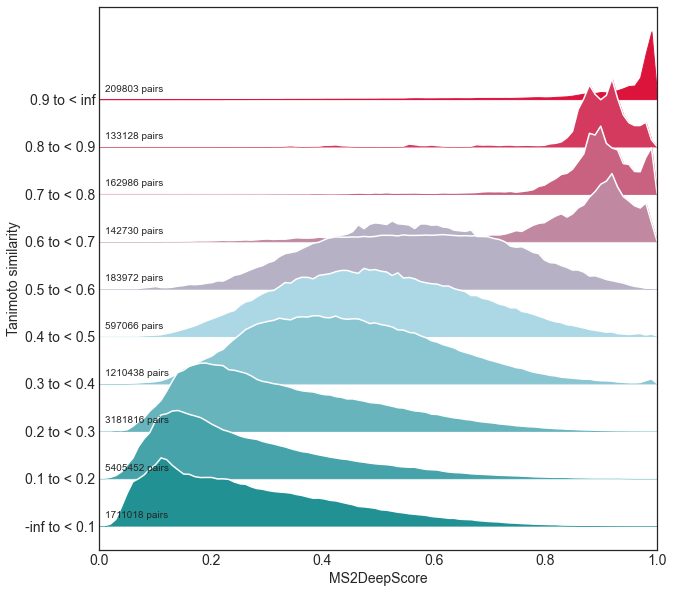

In [230]:
#from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, predictions_500, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")


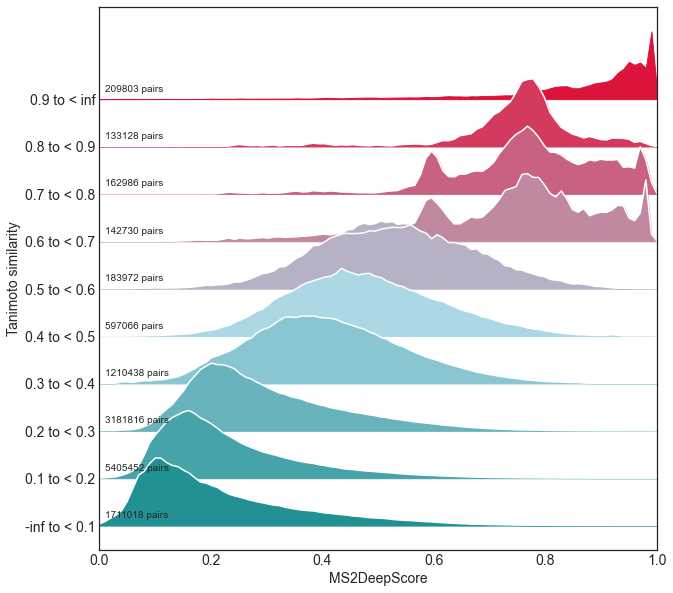

In [229]:
create_histograms_plot(scores_ref, predictions_ensemble[-2, :, :], n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

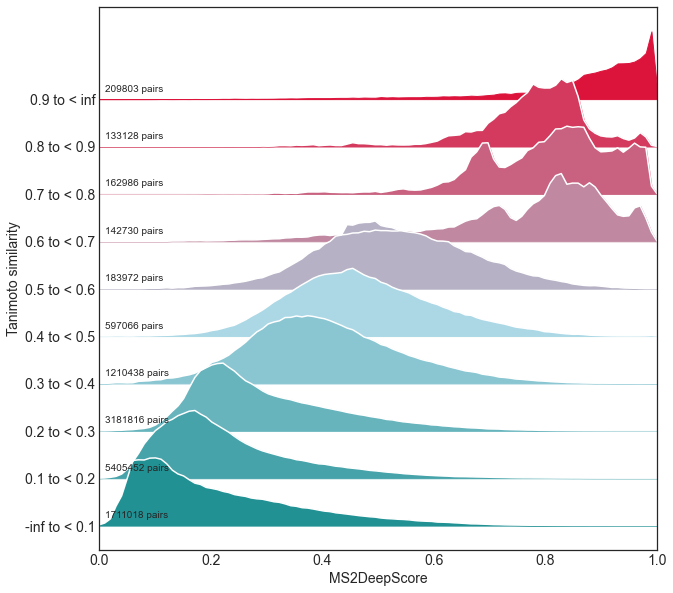

In [224]:
create_histograms_plot(scores_ref, predictions_ensemble[-1, :, :], n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

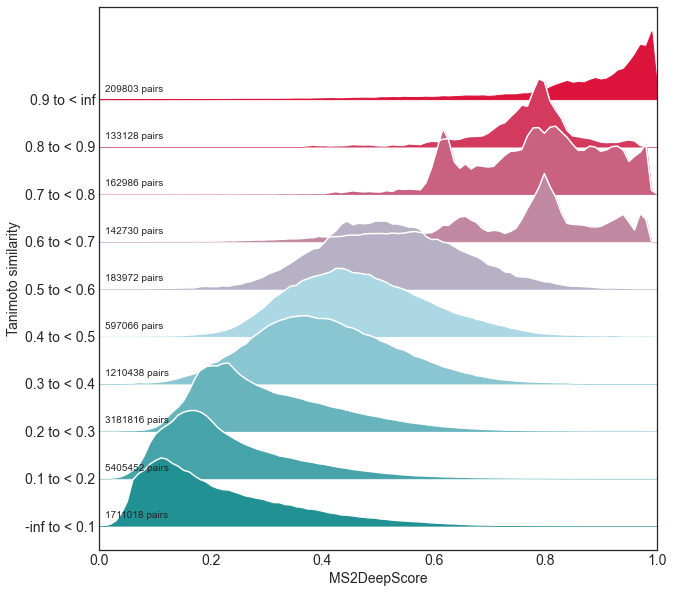

In [228]:
#from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, np.median(predictions_ensemble, axis=0), n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

filename = os.path.join(path_models, "trained_models",
                        "histogram_1k_15k_ensemble_model.pdf")
plt.savefig(filename)